In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 생성자 모델
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D()) # 이미지 확대 역할
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
# 판별자 모델
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [4]:
# 생성자와 판별자 모델을 연결시키는 gan 모델
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0  d_loss:0.4994  g_loss:0.2334
epoch:1  d_loss:0.4882  g_loss:0.0812
epoch:2  d_loss:0.5323  g_loss:0.0527
epoch:3  d_loss:0.5200  g_loss:0.0847
epoch:4  d_loss:0.4876  g_loss:0.1899
epoch:5  d_loss:0.4570  g_loss:0.3764
epoch:6  d_loss:0.4540  g_loss:0.5248
epoch:7  d_loss:0.4460  g_loss:0.6037
epoch:8  d_loss:0.4316  g_loss:0.6637
epoch:9  d_loss:0.4548  g_loss:0.6427
epoch:10  d_loss:0.4454  g_loss:0.6509
epoch:11  d_loss:0.5071  g_loss:0.5626
epoch:12  d_loss:0.5523  g_loss:0.5209
epoch:13  d_loss:0.5090  g_loss:0.5735
epoch:14  d_loss:0.4188  g_loss:0.5343
epoch:15  d_loss:0.3810  g_loss:0.3479
epoch:16  d_loss:0.3297  g_loss:0.1918
epoch:17  d_loss:0.2469  g_loss:0.1247
epoch:18  d_loss:0.2004  g_loss:0.1600
epoch:19  d_loss:0.1737  g_loss:0.2860
epoch:20  d_loss:0.2054  g_loss:0.1713
epoch:21  d_loss:0.2571  g_loss:0.1717
epoch:22  d_loss:0.2530  g_loss:0.5661
epoch:23  d_loss:0.5759  g_loss:0.1599
epoch:24  d_loss:0.5359  g_loss:0.4841
epoch:25  d_loss:0.7517  g_loss:0.5

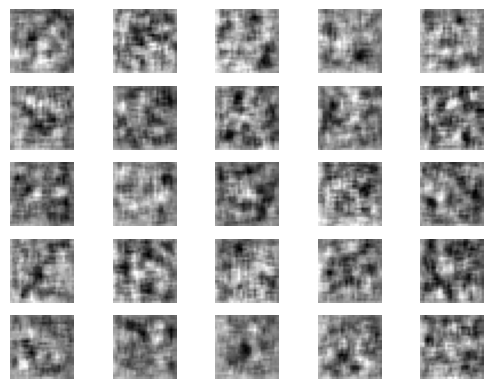

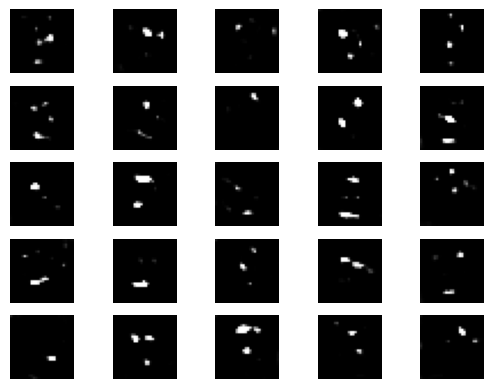

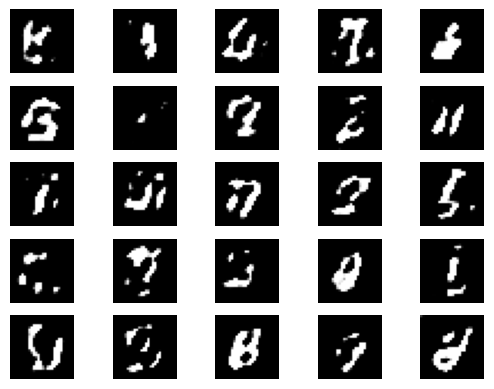

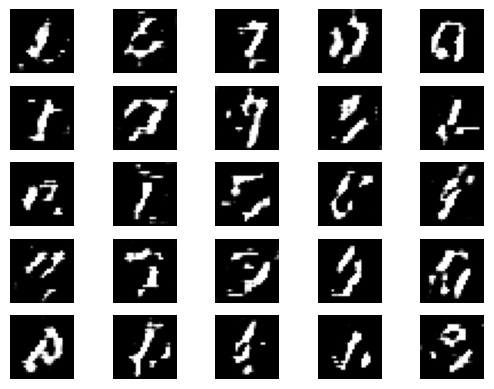

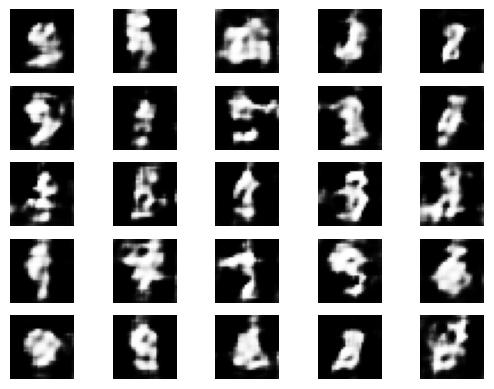

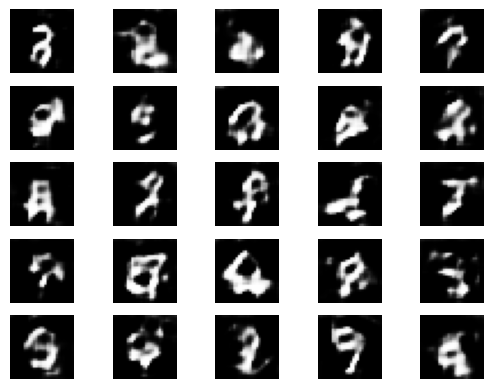

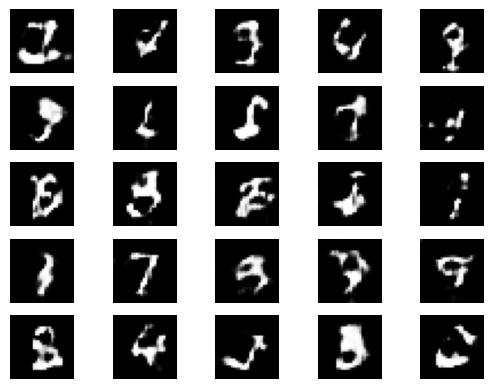

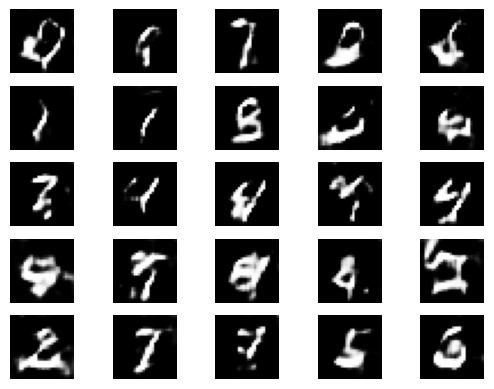

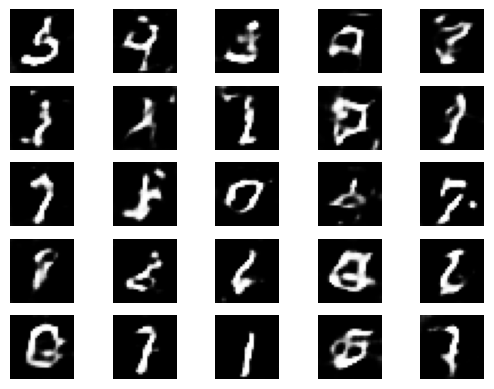

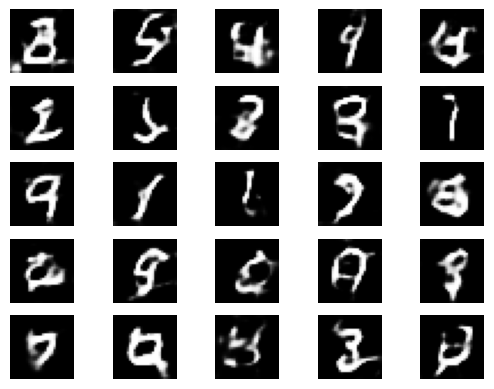

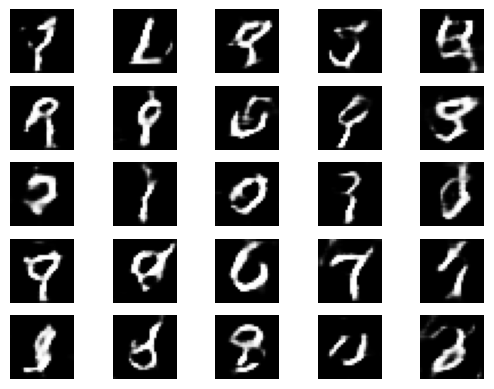

In [6]:
# 신경망을 실행시키는 함수
def gan_train(epoch, batch_size, saving_interval):
  # MNIST 데이터를 불러옵니다.
  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분
        #이미지들은 gan_images 폴더에 저장
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              # 아래 코드는 폴더를 data/gan_images 폴더를 만들어야함
              fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장